# Exploratory Data Analysis (EDA) - variable study 
---
* **Overview default data**
<br />Use [train.csv](../data/train.csv) to do analysis, containing $1\,458\,644$ trips.

| Name | Description | type | unit |
| :----: | :---- | :----: | :----: | 
| id | a unique identifier for each trip | object |  |
| vendor_id | a code indicating the provider associated with the trip record | int | |
| pickup_datetime | date and time when the meter was engaged | object | |
| dropoff_datetime | date and time when the meter was disengaged (not in test data)| object | |
| passenger_count | the number of passengers in the vehicle (driver entered value) | int | people |
| pickup_longitude | the longitude where the meter was engaged | float | degree |
| pickup_latitude | the latitude where the meter was engaged | float | degree |
| dropoff_longitude | the longitude where the meter was disengaged | float | degree | 
| dropoff_latitude | the latitude where the meter was disengaged | float | degree |
| store_and_fwd_flag | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip | object | |
| trip_duration | duration of the trip | int | second |

---
## Import modules & function defination

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import string

In [2]:
import re, calendar, time, datetime

### General function for creating/adding column
def create_feature( dataframe, useColName, func, **kwds):
    return dataframe[useColName].apply(func, **kwds)
    
def add_column( dataframe, newColName, column ):
    df = dataframe.copy()
    df[newColName] = column
    return df

### Extract datetime
# Label the datetimes
datetime_list,  datetime_dict = [ 'year', 'month', 'day', 'hour', 'minute', 'second'], {}
for i, name in enumerate(datetime_list): datetime_dict[name] = i

# Split datetime by space   
def split_datetime(date_str):
    # e.g. 2016-03-26 13:30:55 -> 2016 03 26 13 30 55 
    datetime = re.sub(r'(.*)-(.*)-(.*) (.*):(.*):(.*)', r'\1 \2 \3 \4 \5 \6', date_str)
    return datetime.split()

# Get each datetime's value by label/index
def get_datetime(date_str, idx, debug=False):
    if type(idx) is str: 
        i = datetime_dict[idx]
    else:
        i = int(idx)
    if debug: 
        print 'Input %s, output %d, %s'%(str(idx), i, datetime_list[i]) 
    return int(split_datetime(date_str)[i])

# Other : Get each datetime's value
def get_year(date_str):
    return get_datetime(date_str, 'year')

def get_month(date_str):
    return get_datetime(date_str, 'month')

def get_day(date_str):
    return get_datetime(date_str, 'day')

def get_hour(date_str):
    return get_datetime(date_str, 'hour')

def get_minute(date_str):
    return get_datetime(date_str, 'minute')

def get_second(date_str):
    return get_datetime(date_str, 'second')

def get_time(date_str):
    return get_hour(date_str) + get_minute(date_str)/60. + get_second(date_str)/60./60.

def get_weekday(date_str):
    return datetime.date(get_year(date_str), get_month(date_str), get_day(date_str)).isoweekday() 

def get_timestamp(date_str):
    return int(time.mktime(time.strptime(date_str, '%Y-%m-%d %H:%M:%S')))

### For cross-check
# get_datetime('2016-03-26 13:30:55', 2)
# get_datetime('2016-03-26 13:30:55', 'year')
#
#import datetime
#a = create_feature(df, 'pickup_datetime', get_timestamp )
#print a[0]
#print datetime.datetime.fromtimestamp(int(a[0]))
#print df['pickup_datetime'][0]

In [3]:
def make_hist( X, xmax=None, xmin=None, binw=1, xlabel='Input', ylabel='Counts', xunit='', edgecolor='black', tightLabel=False, centerLabel=False, debug=False, log=False, **hist_kwds ):    
    if not xmax:
        xmax = max(X)+binw
    if not xmin:
        xmin = min(X) if (min(X) < 0) or (min(X) >=1) else 0 
        
    if xmax <= xmin: 
        xmax = max(X)+binw
        xmin = min(X) if (min(X) < 0) or (min(X) >=1) else 0 

    hist_info_ = plt.hist( 
                           x = X[ (X <= xmax) & (X >= xmin) ],
                           bins = np.arange(xmin, xmax+binw, binw), # Due to end 2 bins are 1, hist will combined them to a bin. 
                           edgecolor = edgecolor,
                           log=log,
                           **hist_kwds
                         )
    
    if xunit == '': 
        ylabel = ylabel+' / %.2f'%(binw)
    else:
        xlabel = xlabel+' [%s]'%(xunit)
        ylabel = ylabel+' / %.2f %s'%(binw, xunit)
    plt.tick_params(labelsize=20)
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)
    plt.ylim(ymin = 0.5 if log else 0)
    
    # Show label be bin by bin
    if tightLabel: 
        plt.xticks(hist_info_[1])
    
    # Make label be in bins' center
    if tightLabel and centerLabel:
        ax_min = min(hist_info_[1])
        ax_max = max(hist_info_[1])
        ax_wth = (hist_info_[1][1]-hist_info_[1][0])/2.
        newrange = np.arange(ax_min, ax_max+ax_wth, ax_wth)
        newnames, n = [], 0
        for i in range(len(newrange)):
            if i%2 == 0: 
                newnames.append('')
            elif n < len(hist_info_[1]): 
                v = hist_info_[1][n] if hist_info_[1][n]%1 != 0 else int(hist_info_[1][n])
                newnames.append(v)
                n+=1   
        plt.xticks(newrange, newnames)
        if debug: print ax_min, ax_max, ax_wth, newrange

    return hist_info_

---
## Load & check data

In [4]:
#df = pd.read_csv('../data/train.csv')
df = pd.read_csv('../data/train_mini.scv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 11 columns):
id                    999 non-null object
vendor_id             999 non-null int64
pickup_datetime       999 non-null object
dropoff_datetime      999 non-null object
passenger_count       999 non-null int64
pickup_longitude      999 non-null float64
pickup_latitude       999 non-null float64
dropoff_longitude     999 non-null float64
dropoff_latitude      999 non-null float64
store_and_fwd_flag    999 non-null object
trip_duration         999 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 85.9+ KB


In [6]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


---
## Overview default variables
### 1. *Id*
A unique identifier for each trip.

In [7]:
print len(df.id.unique())
df.__delitem__('id')

999


Currently, it seems not to have any special feature here. It's just a data label. So it is removed.

### 2. *vendor_id*
A code indicating the provider associated with the trip record.

In [8]:
types = np.sort(df.vendor_id.unique())
print 'Value types:', types

Value types: [1 2]


In [9]:
sums = df.vendor_id.value_counts()
print sums

2    528
1    471
Name: vendor_id, dtype: int64


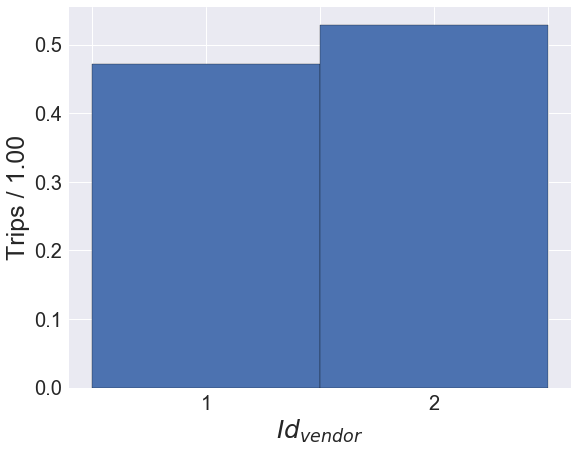

Trip rate of vendor_id [1, 2] = [ 0.47147147  0.52852853]


In [10]:
X = df[['vendor_id']].values

plt.figure(figsize=[9,7])
hist_info = make_hist(X, xlabel=r'$Id_{vendor}$', ylabel='Trips', normed=True, tightLabel=True, centerLabel=True)
plt.show()
print 'Trip rate of vendor_id [1, 2] =', hist_info[0]

Only two vendor id exist in the data and with reasonable equal size.

### 3. Vriables about date & time - *pickup_datetime, dropoff_datetime, trip_duration*
Date and time when the meter was **engaged** & **disengaged**<br />
**3.1. Check content type** 

In [11]:
print df['pickup_datetime'][0:5]
print 'Value type :', type(df['pickup_datetime'][0])

0    2016-03-14 17:24:55
1    2016-06-12 00:43:35
2    2016-01-19 11:35:24
3    2016-04-06 19:32:31
4    2016-03-26 13:30:55
Name: pickup_datetime, dtype: object
Value type : <type 'str'>


**3.2. Add/remove columns to/from dataframe** 

In [12]:
for situation in ['pickup', 'dropoff']:
    # Record execution time
    start_time = time.time()
    print 'Extracting '+situation+'_datetime....'
    
    # Add year
    newcol = create_feature(df, situation+'_datetime', get_datetime, idx='year')
    df = add_column(df, situation+'_year', newcol)
    
    # Add month
    newcol = create_feature(df, situation+'_datetime', get_datetime, idx='month')
    df = add_column(df, situation+'_month', newcol)
    
    # Add day
    newcol = create_feature(df, situation+'_datetime', get_datetime, idx='day')
    df = add_column(df, situation+'_day', newcol)
    
    # Add time
    newcol = create_feature(df, situation+'_datetime', get_time)
    df = add_column(df, situation+'_time', newcol)
        
    # Add weekday
    newcol = create_feature(df, situation+'_datetime', get_weekday)
    df = add_column(df, situation+'_weekday', newcol)

    # Add timestamp
    newcol = create_feature(df, situation+'_datetime', get_timestamp)
    df = add_column(df, situation+'_timestamp', newcol)
    
    ## Add splitted datetime columns
    #for i, name in enumerate(datetime_list):
    #    newcol = create_feature(df, situation+'_datetime', get_datetime, idx=i)
    #    df = add_column(df, situation+'_'+name, newcol)
    
    print 'Done : %s sec.'% str(time.time() - start_time)

Extracting pickup_datetime....
Done : 0.182888031006 sec.
Extracting dropoff_datetime....
Done : 0.175797224045 sec.


In [13]:
# Remove datetime (str)
df.__delitem__('pickup_datetime')
df.__delitem__('dropoff_datetime')
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_year,pickup_month,pickup_day,pickup_time,pickup_weekday,pickup_timestamp,dropoff_year,dropoff_month,dropoff_day,dropoff_time,dropoff_weekday,dropoff_timestamp
0,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016,3,14,17.415278,1,1457947495,2016,3,14,17.541667,1,1457947950
1,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016,6,12,0.726389,7,1465663415,2016,6,12,0.910556,7,1465664078
2,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016,1,19,11.590000,2,1453174524,2016,1,19,12.180000,2,1453176648
3,2,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016,4,6,19.541944,3,1459942351,2016,4,6,19.661111,3,1459942780
4,2,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016,3,26,13.515278,6,1458970255,2016,3,26,13.636111,6,1458970690


**3.3 Check year**

In [14]:
print np.unique(df['pickup_year']), np.unique(df['dropoff_year'])

[2016] [2016]


In [15]:
# Remove year
df.__delitem__('pickup_year')
df.__delitem__('dropoff_year')
df.head()
#df.to_csv('../data/train_timefixed.csv', index=False)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_day,pickup_time,pickup_weekday,pickup_timestamp,dropoff_month,dropoff_day,dropoff_time,dropoff_weekday,dropoff_timestamp
0,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,14,17.415278,1,1457947495,3,14,17.541667,1,1457947950
1,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,12,0.726389,7,1465663415,6,12,0.910556,7,1465664078
2,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,19,11.590000,2,1453174524,1,19,12.180000,2,1453176648
3,2,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,6,19.541944,3,1459942351,4,6,19.661111,3,1459942780
4,2,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,26,13.515278,6,1458970255,3,26,13.636111,6,1458970690


* Remove the year column, since they are all the same.

In [16]:
df = pd.read_csv('../data/train_timefixed.csv')
#df.head()

**3.4 Distribution of month, day, time, weekday**

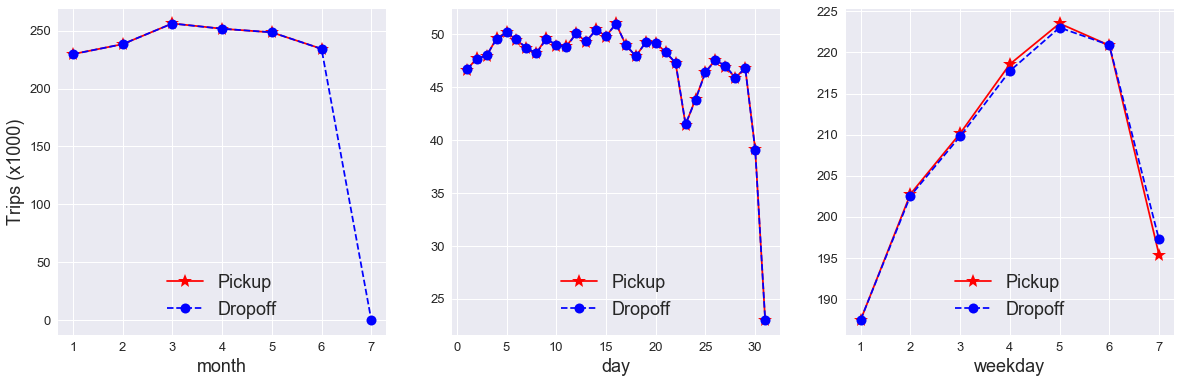

In [17]:
nomalize=1000 # tirps
fig, ax = plt.subplots(ncols=3, sharey=False)
fig.set_size_inches(20,6)
for i, name in enumerate(['month', 'day', 'weekday']):
    ax[i].plot(df.groupby('pickup_'+name).count()['vendor_id']/nomalize,  'r-*',  markersize=15,  label='Pickup')
    ax[i].plot(df.groupby('dropoff_'+name).count()['vendor_id']/nomalize, 'b--o', markersize=10, label='Dropoff')
    ax[i].legend(loc='lower center', fontsize=18)
    ax[i].tick_params(labelsize=13)
    ax[i].set_xlabel( name, fontsize=18)
    if i is 0: 
        ax[i].set_ylabel('Trips (x%d)'%nomalize, fontsize=18)
plt.show()

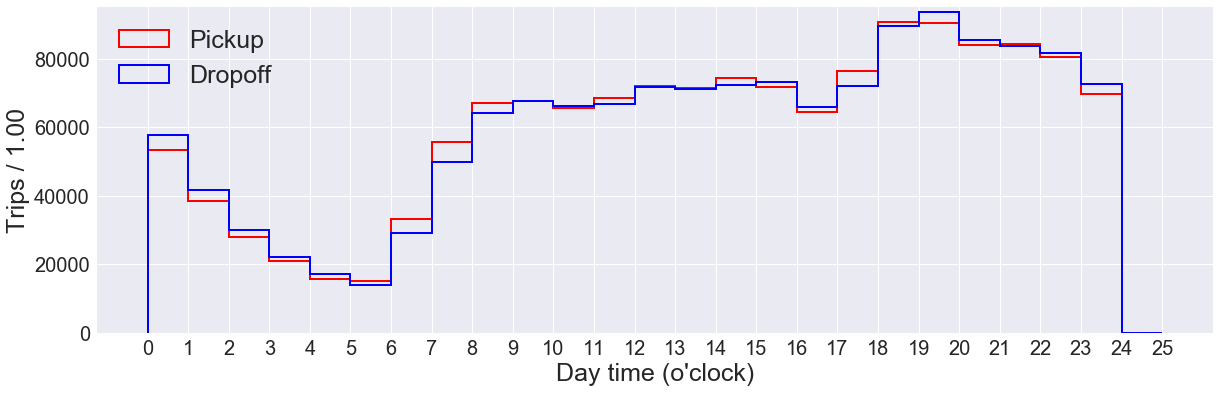

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Pickup,53248,38571,27972,20895,15792,15002,33248,55600,67053,67663,...,74292,71811,64313,76483,90600,90308,84072,84185,80492,69785
Dropoff,57811,41760,29845,22086,17037,14038,29234,49939,64105,67527,...,72390,73109,65917,72020,89588,93431,85337,83619,81568,72596


In [18]:
plt.figure(figsize=(20,6))
pick_info = make_hist(df['pickup_time'].values,  xmax=25, histtype='step', edgecolor='r', linewidth=2, xlabel="Day time (o'clock)", ylabel="Trips", label='Pickup',  tightLabel=True)
drop_info = make_hist(df['dropoff_time'].values, xmax=25, histtype='step', edgecolor='b', linewidth=2, xlabel="Day time (o'clock)", ylabel="Trips", label='Dropoff', tightLabel=True)
plt.legend(loc='upper left', fontsize=25)
plt.show()

df_trips_daytime = pd.DataFrame(data=[pick_info[0][:-1].astype(int), drop_info[0][:-1].astype(int)], columns=range(0,24,1), index=['Pickup','Dropoff'])
df_trips_daytime.head() 

* Data has only **6 months** records. Each Month has about **common trip yields**. July is only recorded in dropoff, i.e. the pickup time is midnight of 30th June.
* Day can be said it has **common trip yields**, except of the falling in 23 which has be known in Yen's analysis. 31 has big falling, since only 5 month has 31.
* Weekday shows the taxi usage increases slowly to the maximum (**Friday**) and decreases quickly to **Monday** again.
* Day time show the high texi usage is after work (**18hr**). The trips rate decrease after midnight.  
* Apperently, the **weekday** and **day time** may can be used for training, since they have own probabilty distribution of trips. But they has to be check the correlation with duration.

**3.5 Trip durations (target value)**

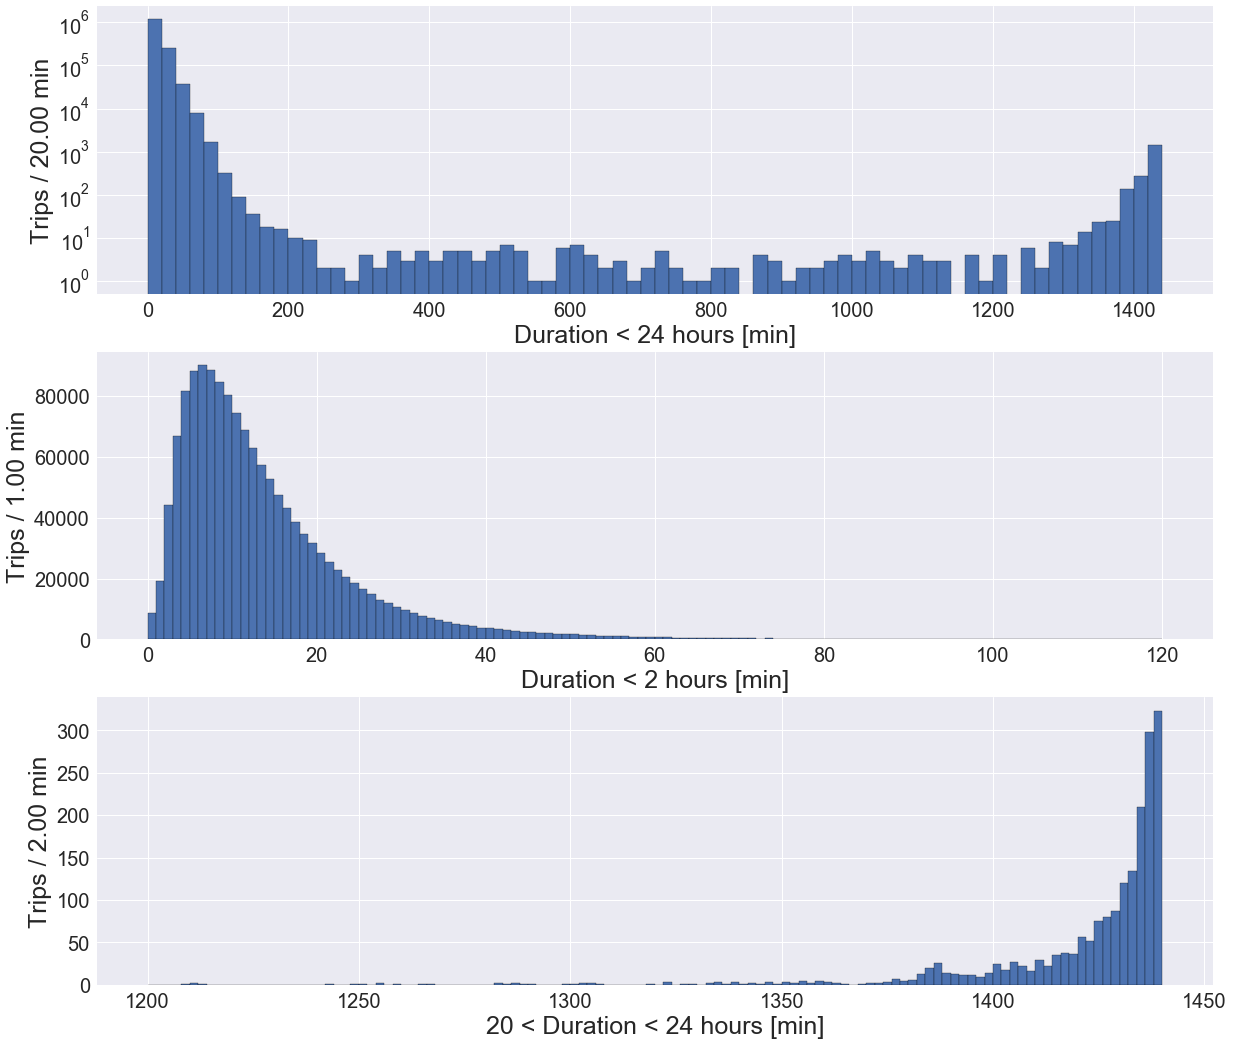

In [19]:
X_min = df['trip_duration'].values/60
fig = plt.figure(figsize=(20,18))
fig.add_subplot(3,1,1)
make_hist(X_min, xmax=24*60, xmin=0,     binw=20, xlabel='Duration < %d hours'%(24),          xunit='min', ylabel='Trips', log=True)
fig.add_subplot(3,1,2)
make_hist(X_min, xmax=2*60,  xmin=0,     binw=1,  xlabel='Duration < %d hours'%(2),           xunit='min', ylabel='Trips', log=False)
fig.add_subplot(3,1,3)
make_hist(X_min, xmax=24*60, xmin=20*60, binw=2,  xlabel='%d < Duration < %d hours'%(20, 24), xunit='min', ylabel='Trips', log=False)
plt.show()

**3.6 Cross-Check duration v.s. timestamp**

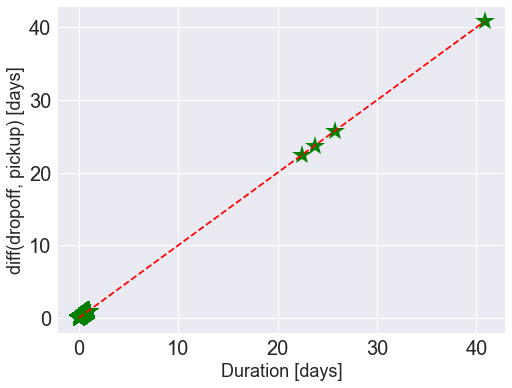

In [20]:
# Get values with array, float type
x = df['trip_duration'].values.astype(float)
y = (df['dropoff_timestamp']-df['pickup_timestamp']).values.astype(float)

x_hr, x_day, y_day = x/60/60, x/60/60/24, y/60/60/24

# Linear fit x-y
pars = np.polyfit(x_day, y_day, deg=1)
xf = np.linspace(0., max(x_day), 100)
yf = np.poly1d(pars)(xf)

plt.figure(figsize=(8,6))
plt.plot( x_day, y_day, 'g*', xf, yf, 'r--', markersize=20)
plt.tick_params(labelsize=20)
plt.xlabel('Duration [days]', fontsize=18)
plt.ylabel('diff(dropoff, pickup) [days]', fontsize=18)
plt.show()

In [21]:
print 'Linear fit y = x*%.2f + %.2f '%( pars[0], pars[1])
print '[NOTE] %d trips are out of %d days'%( len(x[ x > 24*60*60 ]), 1 )
print df.loc[df['trip_duration'] > 24*60*60 ]['trip_duration']
df[df['trip_duration'] > 24*60*60 ]

Linear fit y = x*1.00 + -0.00 
[NOTE] 4 trips are out of 1 days
355003    1939736
680594    2049578
924150    2227612
978383    3526282
Name: trip_duration, dtype: int64


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_day,pickup_time,pickup_weekday,pickup_timestamp,dropoff_month,dropoff_day,dropoff_time,dropoff_weekday,dropoff_timestamp
355003,1,1,-73.789650,40.643559,-73.956810,40.773087,N,1939736,1,5,0.328333,2,1451924382,1,27,11.143889,3,1453864118
680594,1,2,-73.921677,40.735252,-73.984749,40.759979,N,2049578,2,13,22.633333,6,1455374280,3,8,15.960556,2,1457423858
924150,1,1,-73.983788,40.742325,-73.985489,40.727676,N,2227612,1,5,6.237500,2,1451945655,1,31,1.018611,7,1454173267
978383,1,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282,2,13,22.781111,6,1455374812,3,25,18.303889,5,1458901094


* The duration in data is correct by comapring with timestamps between pickup & dropoff. The **fitted slope = 1**, **intercept = 0**. 
* There are **4 trips** having strange long duration. Need to check the distance v.s. duration, it can show if the duration in reasonable distance. Or the time clock was fogetten to closed. 

### 4. Passenge counts
The number of passengers in the vehicle (driver entered value)<br />

In [22]:
bins = np.unique(df['passenger_count'].values)
print bins

[0 1 2 3 4 5 6 7 8 9]


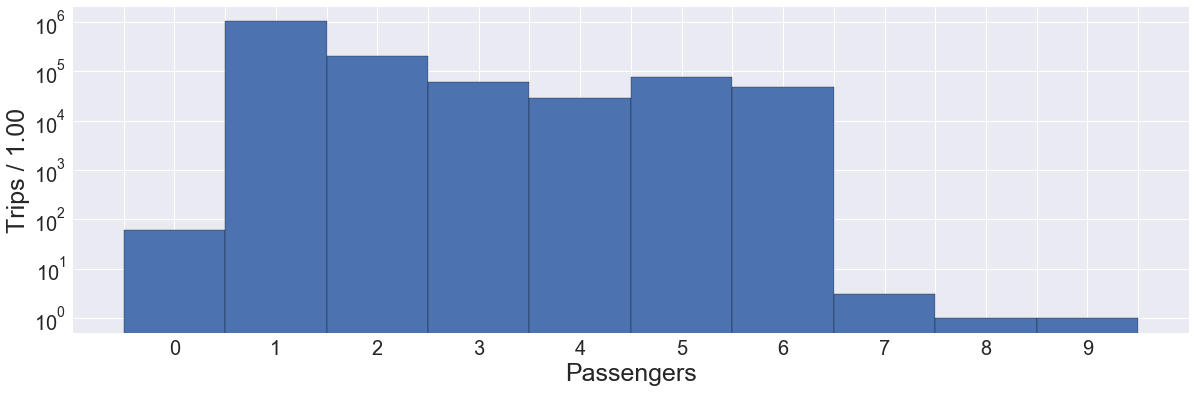

,0,1,2,3,4,5,6,7,8,9
Trips,60,1033540,210318,59896,28404,78088,48333,3,1,1


In [23]:
plt.figure(figsize=(20,6))
hist_info = make_hist(df['passenger_count'].values, xlabel='Passengers', ylabel='Trips', log=True, tightLabel=True, centerLabel=True)
plt.show()
df_trips_passenger = pd.DataFrame(data=[hist_info[0].astype(int)], columns=range(len(bins)), index=['Trips'])
df_trips_passenger.head() 

* Most of the case is with **1**.
* The passender with **5** & **6** cases slightly increase, maybe the texi is a **big size** which is an hiden fearture.
* Interest 2D check v.s. : duration, daytime, weekday, vandor ID, direction.
* Why there is zero? Check its duration, daytime

### 5. Flag of recording whether in vehicle - *store_and_fwd_flag*
This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, because the vehicle did not have a connection to the server<br/ >
> Y = store and forward<br />
> N = not a store and forward trip.

In [24]:
X = df['store_and_fwd_flag'].values
np.unique(X)

array(['N', 'Y'], dtype=object)

In [25]:
def NY2bool(ny_str):
    return 1 if ny_str.upper() == 'Y' else 0

newcol = create_feature(df, 'store_and_fwd_flag', NY2bool)
df.__delitem__('store_and_fwd_flag')
df = add_column(df, 'store_and_fwd_flag', newcol)
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,pickup_day,pickup_time,pickup_weekday,pickup_timestamp,dropoff_month,dropoff_day,dropoff_time,dropoff_weekday,dropoff_timestamp,store_and_fwd_flag
0,2,1,-73.982155,40.767937,-73.964630,40.765602,455,3,14,17.415278,1,1457947495,3,14,17.541667,1,1457947950,0
1,1,1,-73.980415,40.738564,-73.999481,40.731152,663,6,12,0.726389,7,1465663415,6,12,0.910556,7,1465664078,0
2,2,1,-73.979027,40.763939,-74.005333,40.710087,2124,1,19,11.590000,2,1453174524,1,19,12.180000,2,1453176648,0
3,2,1,-74.010040,40.719971,-74.012268,40.706718,429,4,6,19.541944,3,1459942351,4,6,19.661111,3,1459942780,0
4,2,1,-73.973053,40.793209,-73.972923,40.782520,435,3,26,13.515278,6,1458970255,3,26,13.636111,6,1458970690,0


In [26]:
X = df['store_and_fwd_flag'].values
types = np.unique(X)
print types

[0 1]


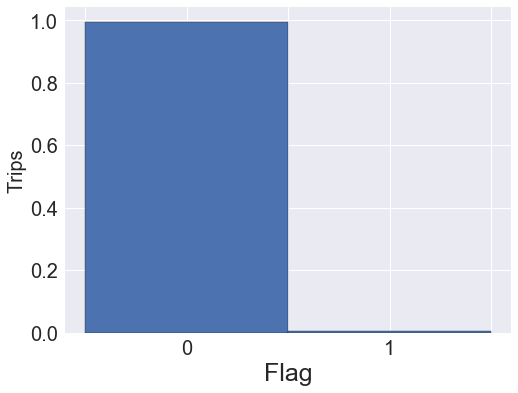

The % of flags [N, Y] = [ 99.44846035   0.55153965]


In [27]:
plt.figure(figsize=[8,6])
hist_info = make_hist(X, xlabel='Flag', ylabel='Trips', normed=True, tightLabel=True, centerLabel=True)
plt.ylabel('Trips', size=20)
plt.show()
print 'The % of flags [N, Y] =', hist_info[0]*100

* About **99.5%** of the recorded trips are **not** stored and sent from vehicle, i.e. the data may have the bias from human mistake.

### 6. Pickup & dropoff location - *pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude*
The longitude/latitude where the meter was engage/disengaged

**6.1\. Overview the coordinates with map**
* **Load subway locations**

In [28]:
df_subway = pd.read_csv('../data/NYC_Subway_Stations_xml.csv')
df_subway.head(5)

,latitude,longitude,stop,sublines,substopid
0,40.799494,-73.968308,103rd St,1,22
1,40.790697,-73.947472,103rd St,6,120
2,40.749804,-73.862436,103rd St,7,173
3,40.796185,-73.961448,103rd St,B C,191
4,40.694955,-73.844727,104-102nd Sts,J Z,327


* **Check histogram of longitude/latitude**

In [29]:
x_pick, x_drop = df['pickup_longitude'], df['dropoff_longitude']
y_pick, y_drop = df['pickup_latitude'],  df['dropoff_latitude']

-73.7766876221 -74.0172195435 40.8424824295 40.6415061951


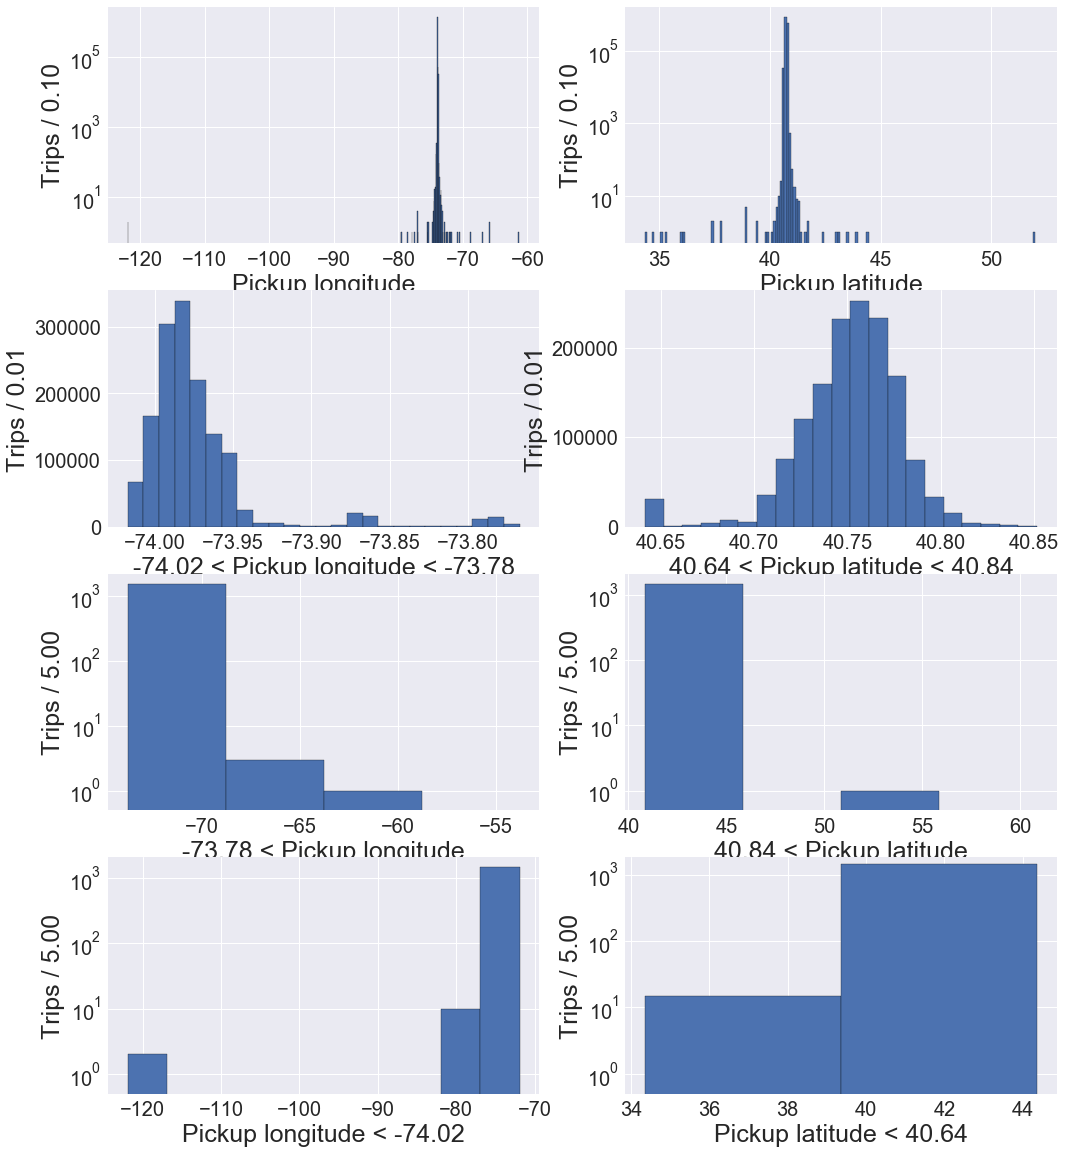

In [30]:
xmax = x_pick.quantile(0.999)
xmin = x_pick.quantile(0.001)
ymax = y_pick.quantile(0.999)
ymin = y_pick.quantile(0.001)
print xmax, xmin, ymax, ymin

fig = plt.figure(figsize=(17,20))
fig.add_subplot(4,2,1)
make_hist(x_pick, binw=0.1, xlabel='Pickup longitude', ylabel='Trips', log=True)
fig.add_subplot(4,2,2)
make_hist(y_pick, binw=0.1, xlabel='Pickup latitude', ylabel='Trips', log=True)
fig.add_subplot(4,2,3)
make_hist(x_pick, xmax=xmax, xmin=xmin, binw=0.01, xlabel='%.2f < Pickup longitude < %.2f'%(xmin, xmax), ylabel='Trips')
fig.add_subplot(4,2,4)
make_hist(y_pick, xmax=ymax, xmin=ymin, binw=0.01, xlabel='%.2f < Pickup latitude < %.2f'%(ymin, ymax), ylabel='Trips')
fig.add_subplot(4,2,5)
make_hist(x_pick, xmin=xmax, binw=5, xlabel='%.2f < Pickup longitude'%(xmax), ylabel='Trips', log=True)
fig.add_subplot(4,2,6)
make_hist(y_pick, xmin=ymax, binw=5, xlabel='%.2f < Pickup latitude'%(ymax), ylabel='Trips', log=True)
fig.add_subplot(4,2,7)
make_hist(x_pick, xmax=xmin, binw=5, xlabel='Pickup longitude < %.2f'%(xmin), ylabel='Trips', log=True)
fig.add_subplot(4,2,8)
make_hist(y_pick, xmax=ymin, binw=5, xlabel='Pickup latitude < %.2f'%(ymin), ylabel='Trips', log=True)
plt.show()

-73.7397575455 -74.1776123047 40.8895519791 40.6042276116


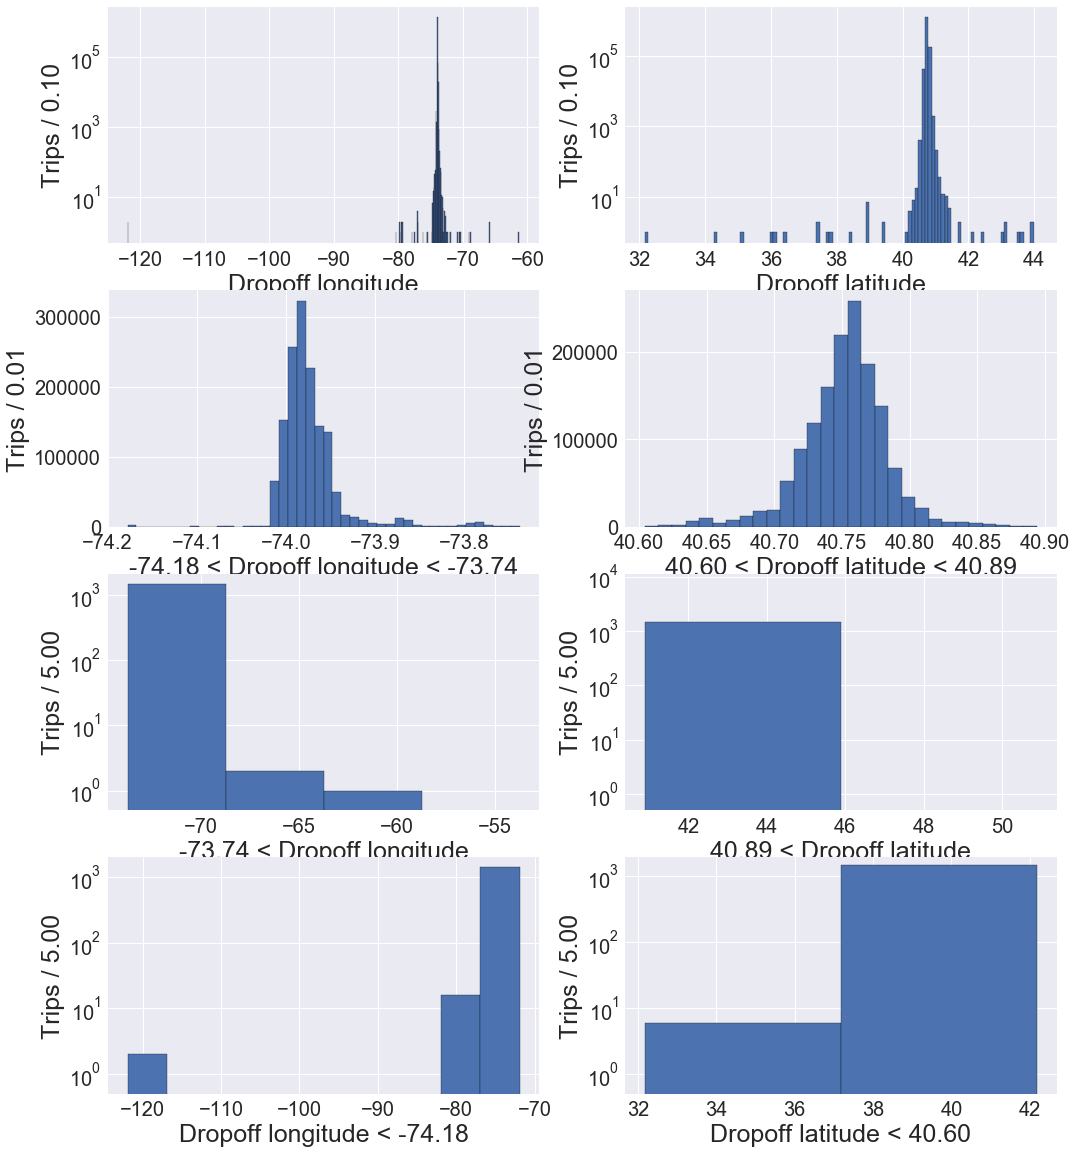

In [31]:
xmax = x_drop.quantile(0.999)
xmin = x_drop.quantile(0.001)
ymax = y_drop.quantile(0.999)
ymin = y_drop.quantile(0.001)
print xmax, xmin, ymax, ymin

fig = plt.figure(figsize=(17,20))
fig.add_subplot(4,2,1)
make_hist(x_drop, binw=0.1, xlabel='Dropoff longitude', ylabel='Trips', log=True)
fig.add_subplot(4,2,2)
make_hist(y_drop, binw=0.1, xlabel='Dropoff latitude', ylabel='Trips', log=True)
fig.add_subplot(4,2,3)
make_hist(x_drop, xmax=xmax, xmin=xmin, binw=0.01, xlabel='%.2f < Dropoff longitude < %.2f'%(xmin, xmax), ylabel='Trips')
fig.add_subplot(4,2,4)
make_hist(y_drop, xmax=ymax, xmin=ymin, binw=0.01, xlabel='%.2f < Dropoff latitude < %.2f'%(ymin, ymax), ylabel='Trips')
fig.add_subplot(4,2,5)
make_hist(x_drop, xmin=xmax, binw=5, xlabel='%.2f < Dropoff longitude'%(xmax), ylabel='Trips', log=True)
fig.add_subplot(4,2,6)
make_hist(y_drop, xmin=ymax, binw=5, xlabel='%.2f < Dropoff latitude'%(ymax), ylabel='Trips', log=True)
fig.add_subplot(4,2,7)
make_hist(x_drop, xmax=xmin, binw=5, xlabel='Dropoff longitude < %.2f'%(xmin), ylabel='Trips', log=True)
fig.add_subplot(4,2,8)
make_hist(y_drop, xmax=ymin, binw=5, xlabel='Dropoff latitude < %.2f'%(ymin), ylabel='Trips', log=True)
plt.show()

* **Show recorded locations in map**

In [32]:
def draw_map( x, y, name, zoom=.1 ):
    cutmap = zoom/100
    x_max, x_min = x.quantile(1-cutmap), x.quantile(cutmap)
    y_max, y_min = y.quantile(1-cutmap), y.quantile(cutmap)

    s = plt.scatter( x=x[(x>x_min) & (x<x_max) & (y<y_max) & (y>y_min)], 
                     y=y[(x>x_min) & (x<x_max) & (y<y_max) & (y>y_min)], 
                     s=5, alpha=0.3)

    plt.tick_params(labelsize=18)
    #plt.title(name, fontsize=18 )
    plt.xlabel('Longitude', fontsize=18)
    plt.ylabel('Latitude',  fontsize=18)
    return s, [x_max, x_min], [y_max, y_min] 

def draw_sub( data_, color='r', marker='*', x_cut=None, y_cut=None, getStop=False ):
    data = data_.copy()
    if x_cut and y_cut:
        data = data[ ( data['longitude'] < x_cut[0] ) & ( data['longitude'] > x_cut[1] ) & 
                     ( data['latitude'] < y_cut[0] )  & ( data['latitude'] > y_cut[1] )]
 
    x, y = data['longitude'], data['latitude']
 
    s = plt.scatter( x=x, y=y, color=color, marker=marker )
    
    subid = []
    if getStop:
        for df in data[['longitude','latitude','substopid']].values:
            plt.text( df[0], df[1], str(int(df[2])), fontsize=15, color='black' )

    return s, data

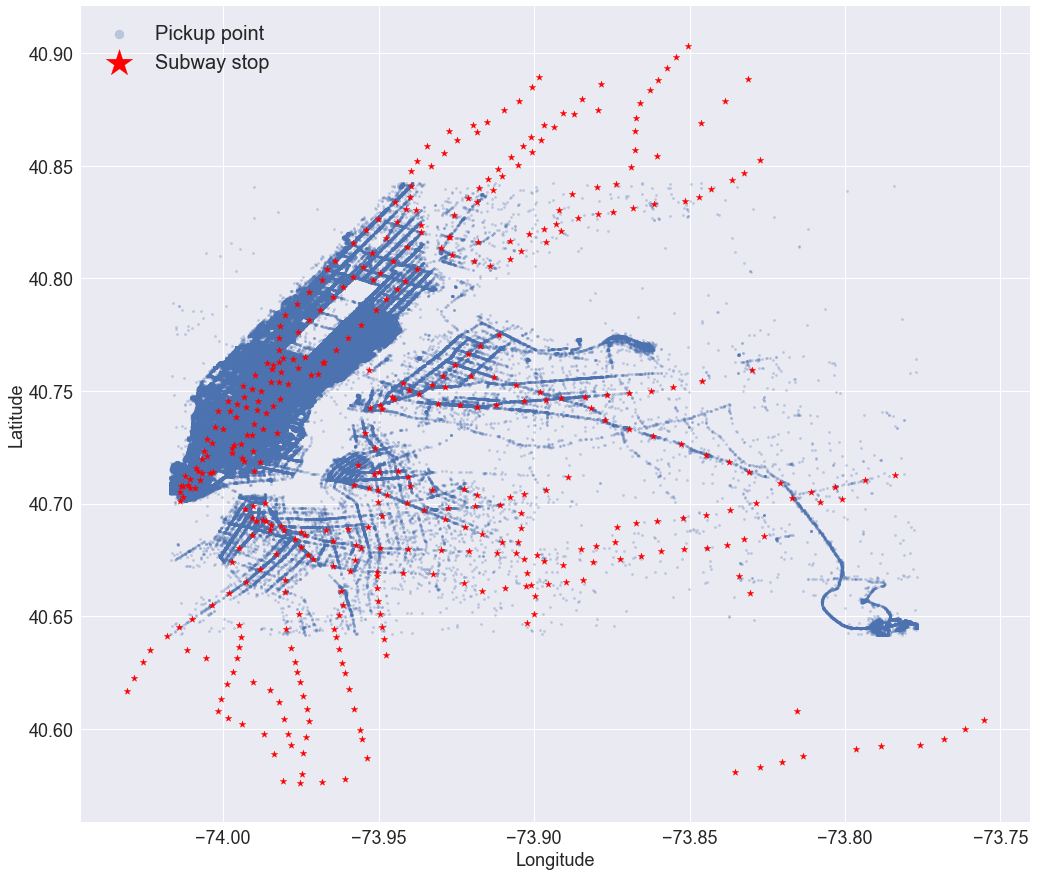

In [33]:
plt.figure(figsize=(17,15))
picks = draw_map(x_pick, y_pick, 'Pickup')
subws = draw_sub(df_subway)
plt.legend((picks[0], subws[0]),
           ('Pickup point', 'Subway stop'),
           loc='upper left',
           markerscale=4,
           fontsize=20)
plt.show()

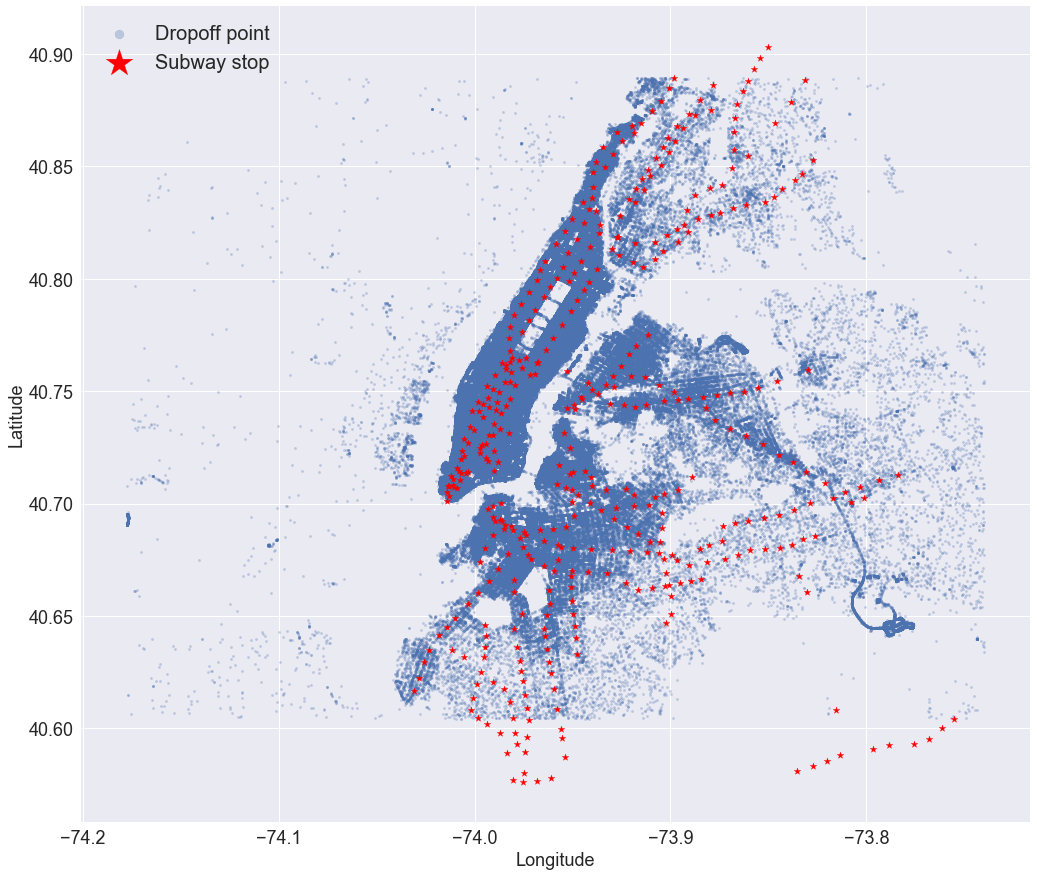

In [34]:
plt.figure(figsize=(17,15))
dorps = draw_map(x_drop, y_drop, 'Dropoff')
subws = draw_sub(df_subway)
plt.legend((dorps[0], subws[0]),
           ('Dropoff point', 'Subway stop'),
           loc='upper left',
           markerscale=4,
           fontsize=20)
plt.show()

* **Zoom in to center of data**

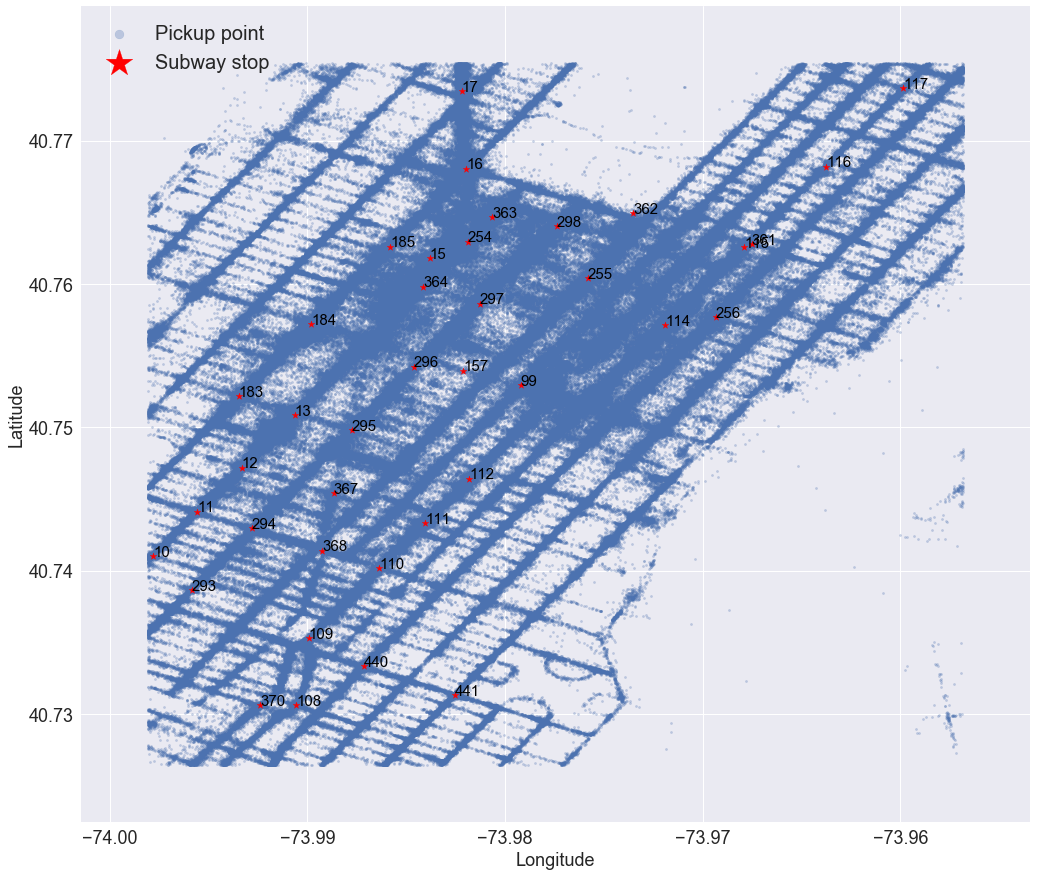

In [35]:
zoom = 15.
plt.figure(figsize=(17,15))
picks, x_cut, y_cut = draw_map(x_pick, y_pick, 'Pickup', zoom=zoom) 
subws, subs = draw_sub(df_subway, x_cut=x_cut, y_cut=y_cut, getStop=True)
plt.legend((picks, subws),
           ('Pickup point', 'Subway stop'),
           loc='upper left',
           markerscale=4,
           fontsize=20)
plt.show()
# Find out the mean center by zoomin

In [36]:
subs_ = subs[['substopid','stop', 'sublines']].sort_values(['substopid'])
print '%d stops inside +/-%.1f%s of region (%.2f < longitude < %.2f), (%.2f < latitude < %.2f)'%( len(subs_), zoom, '%', x_cut[1], x_cut[0], y_cut[1], y_cut[0] )
print subs_.to_string(index=False) #to_latex

39 stops inside +/-15.0% of region (-74.00 < longitude < -73.96), (40.73 < latitude < 40.78)
substopid                            stop             sublines
       10                 18th St-7th Ave                  1 2
       11                 23rd St-7th Ave                  1 2
       12                 28th St-7th Ave                  1 2
       13                 34th St-7th Ave                1 2 3
       15                50th St-Broadway                  1 2
       16         59th St-Columbus Circle          1 2 A B C D
       17                         66th St                  1 2
       99                   Grand Central            4 5 6 7 S
      108                     Astor Place                    6
      109                    Union Square      4 5 6 L N Q R W
      110              23rd St-Park Ave S                    6
      111              28th St-Park Ave S                    6
      112                33rd St-Park Ave                    6
      114      Lexington-

**6.2\. Distribution of distance between pickup - dropoff**

In [37]:
def get_haversine_distance(lng1, lat1, lng2, lat2):
    # km
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  #  km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h 

In [38]:
df['distance'] = pd.DataFrame( get_haversine_distance(df['pickup_longitude'].values,  df['pickup_latitude'].values, 
                               df['dropoff_longitude'].values, df['dropoff_latitude'].values,) )
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,pickup_day,pickup_time,pickup_weekday,pickup_timestamp,dropoff_month,dropoff_day,dropoff_time,dropoff_weekday,dropoff_timestamp,store_and_fwd_flag,distance
0,2,1,-73.982155,40.767937,-73.964630,40.765602,455,3,14,17.415278,1,1457947495,3,14,17.541667,1,1457947950,0,1.498521
1,1,1,-73.980415,40.738564,-73.999481,40.731152,663,6,12,0.726389,7,1465663415,6,12,0.910556,7,1465664078,0,1.805507
2,2,1,-73.979027,40.763939,-74.005333,40.710087,2124,1,19,11.590000,2,1453174524,1,19,12.180000,2,1453176648,0,6.385098
3,2,1,-74.010040,40.719971,-74.012268,40.706718,429,4,6,19.541944,3,1459942351,4,6,19.661111,3,1459942780,0,1.485498
4,2,1,-73.973053,40.793209,-73.972923,40.782520,435,3,26,13.515278,6,1458970255,3,26,13.636111,6,1458970690,0,1.188588


In [39]:
len(df[ df['distance'] == 0])

5897

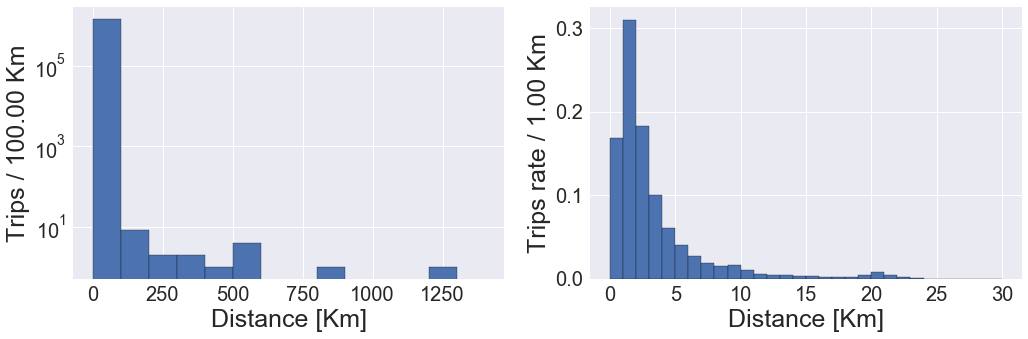

In [40]:
fig = plt.figure(figsize=(17,5))
fig.add_subplot(1,2,1)
make_hist( df['distance'].values, binw=100, xlabel='Distance', xunit='Km', ylabel='Trips', log=True)
fig.add_subplot(1,2,2)
make_hist( df['distance'].values, xmax=30, binw=1, xlabel='Distance', xunit='Km', ylabel='Trips rate', normed=True)
plt.show()

In [44]:
df.to_csv('../data/train_eda.csv', index=False)

### 7. Additional feature

In [45]:
df = pd.read_csv('../data/train_eda_density.csv')
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,pickup_day,pickup_time,...,pick_ylabel,drop_xlabel,drop_ylabel,pick_pixel,drop_pixel,pick_D,pick_Dstd,drop_D,drop_Dstd,dDstd
0,2,1,-73.982155,40.767937,-73.964630,40.765602,455,3,14,17.415278,...,35,44,34,4135,4434,51936.574796,8.665212,37989.983669,7.051886,-1.613326
1,1,1,-73.980415,40.738564,-73.999481,40.731152,663,6,12,0.726389,...,29,37,27,4129,3727,31409.754870,5.181886,32415.876383,5.992918,0.811032
2,2,1,-73.979027,40.763939,-74.005333,40.710087,2124,1,19,11.590000,...,34,36,23,4134,3623,81563.779977,13.692840,18524.282252,3.353795,-10.339044
3,2,1,-74.010040,40.719971,-74.012268,40.706718,429,4,6,19.541944,...,25,35,23,3525,3523,22943.452625,3.745186,19184.246203,3.479175,-0.266011
4,2,1,-73.973053,40.793209,-73.972923,40.782520,435,3,26,13.515278,...,40,42,38,4240,4238,12254.624724,1.931331,23590.476106,4.316270,2.384939


**7.1 Direction**

In [46]:
# get direction (arc tangent angle)
def get_direction(lng1, lat1, lng2, lat2):
    # theta
    AVG_EARTH_RADIUS = 6371  #  km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [48]:
df['direction'] = pd.DataFrame( get_direction(df['pickup_longitude'].values,  df['pickup_latitude'].values, 
                                              df['dropoff_longitude'].values, df['dropoff_latitude'].values))

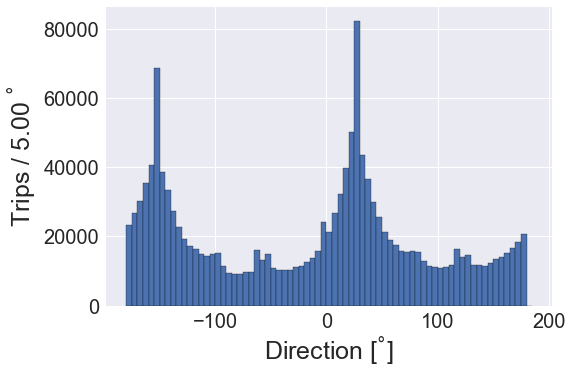

In [63]:
make_hist( df['direction'].values, binw=5, xlabel='Direction', xunit='$^{\degree}$', ylabel='Trips', log=False)
plt.show()

In [92]:
def select_region( df_in, df_ref, name='pickup', zoom=1. ):
    cutmap = zoom/100.
    return df_in[ (df_ref[name+'_longitude'] < df_ref[name+'_longitude'].quantile(1-cutmap)) & 
                  (df_ref[name+'_longitude'] > df_ref[name+'_longitude'].quantile(cutmap))   & 
                  (df_ref[name+'_latitude']  < df_ref[name+'_latitude'].quantile(1-cutmap))  &  
                  (df_ref[name+'_latitude']  > df_ref[name+'_latitude'].quantile(cutmap))  ]

def make_hist2d( x, y, xbinw=1, ybinw=1, xlable='', ylabel='', xmargin=0, ymargin=0, cmap='hot', alpha=0.85, title='', debug=False, **hist2d_kwds):
    xmin, xmax, ymin, ymax = min(x), max(x), min(y), max(y)
    rangex, rangey = [ xmin-xmargin, xmax+xmargin ], [ymin-ymargin, ymax+ymargin]
    bins = [ int((rangex[1]-rangex[0])/xbinw), int((rangey[1]-rangey[0])/ybinw) ]
    counts, xedges, yedges, image = plt.hist2d( x=x, 
                                                y=y,  
                                                range=[rangex, rangey],
                                                bins=bins, 
                                                cmap=cmap, 
                                                alpha=alpha, 
                                                **hist2d_kwds)
    plt.colorbar(image)
    plt.tick_params(labelsize=20)
    plt.title(title, fontsize=25)
    plt.xlabel(xlable, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)
    
    if debug:
        print 'Total  : %d counts'% np.sum(counts)
        print '%d zones has non-zero density'% len(counts[ counts != 0 ])
        print 'Highest density :',np.max(counts)
    
    # counts - dims (2d) = xbins (row) X ybins (culomn)
    # xedges - dims (1d) = xbins + 1
    # yedges - dims (1d) = ybins + 1
    data = { 'counts' : counts.ravel().astype(int),
             'x1' : np.repeat(xedges[:-1],  len(yedges)-1),
             'x2' : np.repeat(xedges[1:],   len(yedges)-1),
             'y1' : np.tile(yedges[:-1],    len(xedges)-1),
             'y2' : np.tile(yedges[1:],     len(xedges)-1) }

    return pd.DataFrame(data=data)

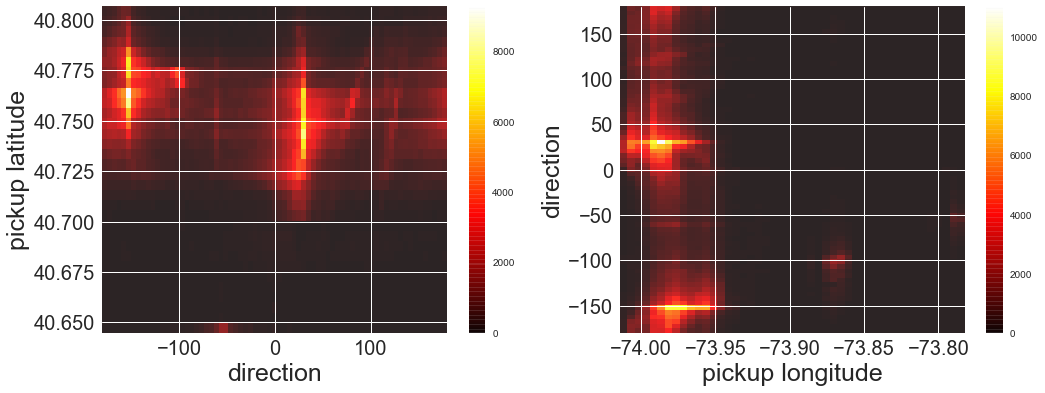

In [98]:
#df_xyd = df.pivot( 'pickup_latitude', 'pickup_longitude', 'direction' )
fig = plt.figure(figsize=(17,6))
fig.add_subplot(1,2,1)
make_hist2d( select_region(df['direction'], df, 'pickup').values, 
             select_region(df['pickup_latitude'], df, 'pickup').values,  
             xlable='direction', ylabel='pickup latitude', xbinw=5, ybinw=0.005, alpha=0.85)
fig.add_subplot(1,2,2)
make_hist2d( select_region(df['pickup_longitude'], df, 'pickup').values, 
             select_region(df['direction'], df, 'pickup').values, 
             xlable='pickup longitude', ylabel='direction', xbinw=0.005, ybinw=5, alpha=0.85)
plt.show()

* The 2 peaks in 30 & -150 is the angle of the island's shape, which means the trips distribute to north-east (30) and south-west (-150). 
* Two airports, JFK 40.65/-73.8, LAG 40.775/-73.87, are with west-like direction. JFK is with -50 degree, LAG is -100 degree, since LAG is much norther than JFK to NYC-center. 

In [51]:
# make label for outlier and in NYC for check the property of outlier

In [42]:
# shortest distance (drop/pick) v.s. duration, sqrt(drop^2+pick^2) v.s. duration

In [43]:
# Add distance between drop/pickup